In [1]:
import pygplates
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions
import pygmt
import numpy as np
import geopandas as gpd

%load_ext autoreload
%autoreload 2


In [2]:
M2019 = Reconstructions.fetch_Muller2019()


In [3]:
topological_model = pygplates.TopologicalModel(
            M2019.dynamic_polygons,
            M2019.rotation_model,
            # Enable strain rate clamping to better control crustal stretching factors...
            default_resolve_topology_parameters=pygplates.ResolveTopologyParameters(enable_strain_rate_clamping=True))


In [4]:
features = pygplates.FeatureCollection('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

#for feature in features:
#    print(feature.get_shapefile_attributes())
#    break


In [10]:
def deform_geometries(gdf, topological_model, reconstruction_time, 
                      initial_time=0, final_time=None,
                      deactivate_points_that_fall_outside_a_network = True):
    
    # Given a geodataframe, will reconstruct using a topological model to a given reconstruction time
    
    # TODO adapt for polylines and polygons
    
    # Do this to detect cases with a mixture of types? (and tell user this isn't supported?)
    # gdf.geom_type.unique()
    
    if not final_time:
        final_time = reconstruction_time
    
    #reconstructed_features_list = []
    
    # Preprocessing:
    gdf = gdf[gdf.geometry.is_valid]   # remove invalid geometries
    gdf = gdf[(gdf.FROMAGE>=reconstruction_time) & (gdf.TOAGE<=reconstruction_time)]   # select points valid at reconstruction time
    gdf = gdf.explode()   # multipart to singlepart
    gdf.reset_index(inplace=True)   # reset index
    
    
    # Should work for points, but for polygon/polyline need to iterate over each feature 
    geometry_points = [(lat,lon) for lat,lon in zip(gdf.geometry.y,gdf.geometry.x)]
    
    time_spans = topological_model.reconstruct_geometry(
                    geometry_points,
                    initial_time=initial_time,
                    oldest_time=final_time,
                    youngest_time=initial_time,
                    # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
                    deactivate_points = pygplates.ReconstructedGeometryTimeSpan.DefaultDeactivatePoints(
                        deactivate_points_that_fall_outside_a_network = deactivate_points_that_fall_outside_a_network))

    reconstructed_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)
    
    #print(reconstructed_points)
    # TODO for cases where this could lead to an array of inconsistent length - maybe should allow points to be 'None'??
    #pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points]))
    valid_index = [reconstructed_point is not None for reconstructed_point in reconstructed_points]
    print(valid_index)
    pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points if reconstructed_point is not None]))

    reconstructed_gdf = gdf.iloc[valid_index]
    reconstructed_gdf = reconstructed_gdf.set_geometry(gpd.points_from_xy(pts[1], pts[0]))
       
    return reconstructed_gdf
    


[True, True, False, False, True, False, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


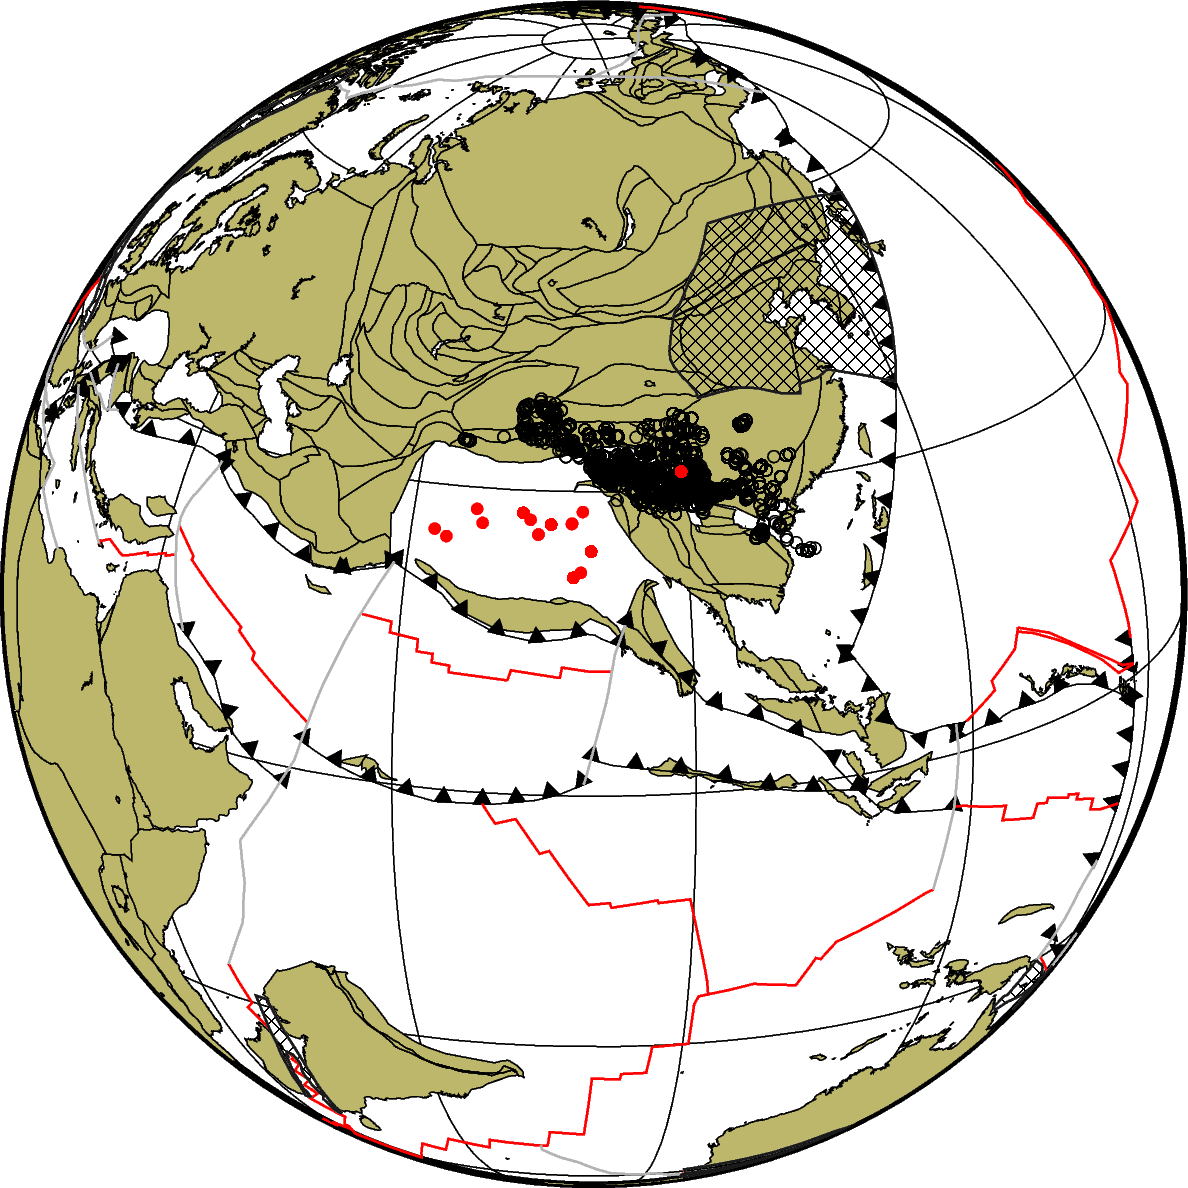

In [15]:
reconstruction_time = 85.

result = deform_geometries(gdf, topological_model, reconstruction_time, deactivate_points_that_fall_outside_a_network=False)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

fig.show(width=800)


In [14]:
result


,level_0,level_1,Data source,sample,Age,Age error,Lat,Long,87Sr/86Sr(i),εNd(t),...,Pb,Th,U,Sr/Y,La/Yb(n),Mg#,A/CNK,FROMAGE,TOAGE,geometry
0,118,0,"Bouilhol et al., 2013",PGUP-16,83.50,2.80,36.192107,73.245370,0.703654,5.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.50,81.50,POINT (62.61998 25.58541)
1,123,0,"Bouilhol et al., 2013",PK05-39,86.00,2.60,35.591948,75.319373,0.703811,5.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.00,84.00,POINT (64.03511 24.96391)
4,628,0,"Coulon et al., 1986",T398,85.00,2.20,31.400000,90.970000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.00,83.00,POINT (78.80359 28.00088)
6,1106,0,"Haider et al., 2013",H-19,85.50,1.50,31.207800,89.778100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.50,83.50,POINT (77.64129 26.81511)
7,1107,0,"Haider et al., 2013",H-20,83.70,1.10,31.220800,89.780400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.70,81.70,POINT (77.64413 26.85532)
8,1269,0,"Horton and Leech, 2013",PT-25_B,85.70,1.40,34.025800,78.176400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.70,83.70,POINT (67.10499 27.88611)
9,1651,0,"Ji et al., 2009",06FW114,86.40,1.60,29.530833,90.993056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.40,84.40,POINT (78.65360 22.08100)
12,2128,0,"Lee et al., 2009",T139,85.80,1.00,31.350000,85.900000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.80,83.80,POINT (74.02988 25.70851)
13,2207,0,"Lee et al., 2012",T139,85.80,NaN,31.350000,85.900000,NaN,NaN,...,31.40,26.20,3.30,3.115854,9.123301,NaN,1.371067,87.80,83.80,POINT (74.02988 25.70851)
14,2815,0,"Liu, D., et al., 2017a",08059B,83.70,NaN,33.291000,79.683330,NaN,2.70,...,12.87,10.91,1.07,45.337027,20.426829,53.00,1.092139,85.70,81.70,POINT (67.86518 26.54464)
